<h1> Brain Tumor Classification (CNN from Scratch) </h1>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
import tensorflow as tf
from tensorflow import keras

In [3]:
#random seed
import random
np.random.seed(1)
tf.random.set_seed(1)

In [4]:
#load file
train_folder = 'D:\\MRI BrainTumor\\Training'
test_folder = 'D:\\MRI BrainTumor\\Testing'

<h3> Split data </h3>

In [5]:
#Training Set
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_folder,
    labels = 'inferred',
    label_mode = 'int',
    image_size = (224, 224),
    batch_size = 32,
    shuffle = True,
    validation_split = 0.2,
    subset = 'training',
    color_mode = 'grayscale',
    seed =1
    
)

Found 5712 files belonging to 4 classes.
Using 4570 files for training.


In [6]:
#Validation Set
val_dataset = tf.keras.utils.image_dataset_from_directory(
    train_folder,
    labels = 'inferred',
    label_mode = 'int',
    image_size = (224,224),
    batch_size= 32,
    shuffle = True,
    validation_split = 0.2,
    subset = 'validation',
    color_mode = 'grayscale',
    seed = 1 
    
)

Found 5712 files belonging to 4 classes.
Using 1142 files for validation.


In [7]:
#Testing Set
test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_folder,
    labels = 'inferred',
    label_mode = 'int',
    image_size = (224,224),
    batch_size = 32,
    color_mode = 'grayscale',
    seed = 1,
    shuffle = False

)

Found 1311 files belonging to 4 classes.


In [8]:
#Define classnames
train_class_names = train_dataset.class_names
val_class_names = val_dataset.class_names
test_class_names = test_dataset.class_names

<h3> Data Visualization </h3>

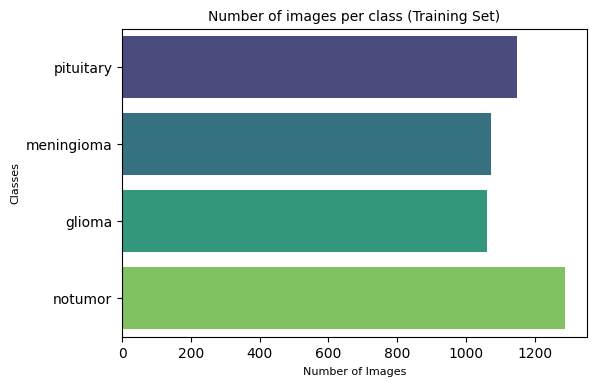

pituitary: 1149
meningioma: 1072
glioma: 1061
notumor: 1288


In [9]:
from collections import Counter

#for training dataset
train_class_counts = Counter()

for _, labels in train_dataset.unbatch():  # Unbatch to access all individual labels
    train_class_counts[int(labels.numpy())] += 1

#map counts to class names
train_class_counts = {train_class_names[class_id]: count for class_id, count in train_class_counts.items()}

#convert to list for plotting
train_class_labels = list(train_class_counts.keys())
train_class_values = list(train_class_counts.values())

#create a countplot (horizontal bar plot)
plt.figure(figsize = (6,4))
sns.barplot(x=train_class_values, y=train_class_labels, hue = train_class_labels, palette = 'viridis')
plt.title('Number of images per class (Training Set)', fontsize = 10)
plt.xlabel("Number of Images", fontsize = 8)
plt.ylabel("Classes", fontsize = 8)
plt.show()

for labels, values in zip(train_class_labels,train_class_values):
    print(f"{labels}: {values}")

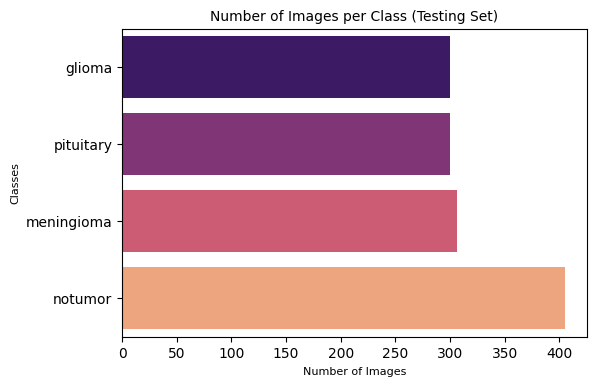

glioma: 300
pituitary: 300
meningioma: 306
notumor: 405


In [10]:
#for testing dataset
test_class_counts = Counter()
for _, labels in test_dataset.unbatch():  
    test_class_counts[int(labels.numpy())] += 1


test_class_counts = {test_class_names[class_id]: count for class_id, count in test_class_counts.items()}
sorted_test_class_counts = dict(sorted(test_class_counts.items(), key=lambda item: item[1]))
test_class_labels = list(sorted_test_class_counts.keys())
test_class_values = list(sorted_test_class_counts.values())


plt.figure(figsize=(6, 4))
sns.barplot(x=test_class_values, y=test_class_labels,hue = test_class_labels, palette="magma")
plt.title("Number of Images per Class (Testing Set)", fontsize=10)
plt.xlabel("Number of Images", fontsize=8)
plt.ylabel("Classes", fontsize=8)
plt.show()


for labels, values in zip(test_class_labels, test_class_values):
    print(f"{labels}: {values}")

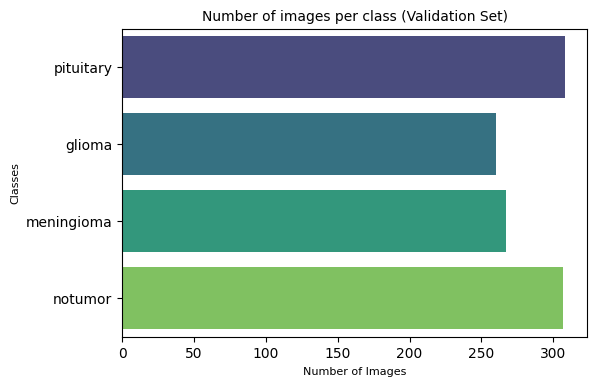

pituitary: 308
glioma: 260
meningioma: 267
notumor: 307


In [11]:
#for validation dataset

val_class_counts = Counter()
for _, labels in val_dataset.unbatch():  # Unbatch to access all individual labels
    val_class_counts[int(labels.numpy())] += 1


val_class_counts = {val_class_names[class_id]: count for class_id, count in val_class_counts.items()}
val_class_labels = list(val_class_counts.keys())
val_class_values = list(val_class_counts.values())


plt.figure(figsize = (6,4))
sns.barplot(x=val_class_values, y=val_class_labels, hue = val_class_labels, palette = 'viridis')
plt.title('Number of images per class (Validation Set)', fontsize = 10)
plt.xlabel("Number of Images", fontsize = 8)
plt.ylabel("Classes", fontsize = 8)
plt.show()

for labels, values in zip(val_class_labels,val_class_values):
    print(f"{labels}: {values}")

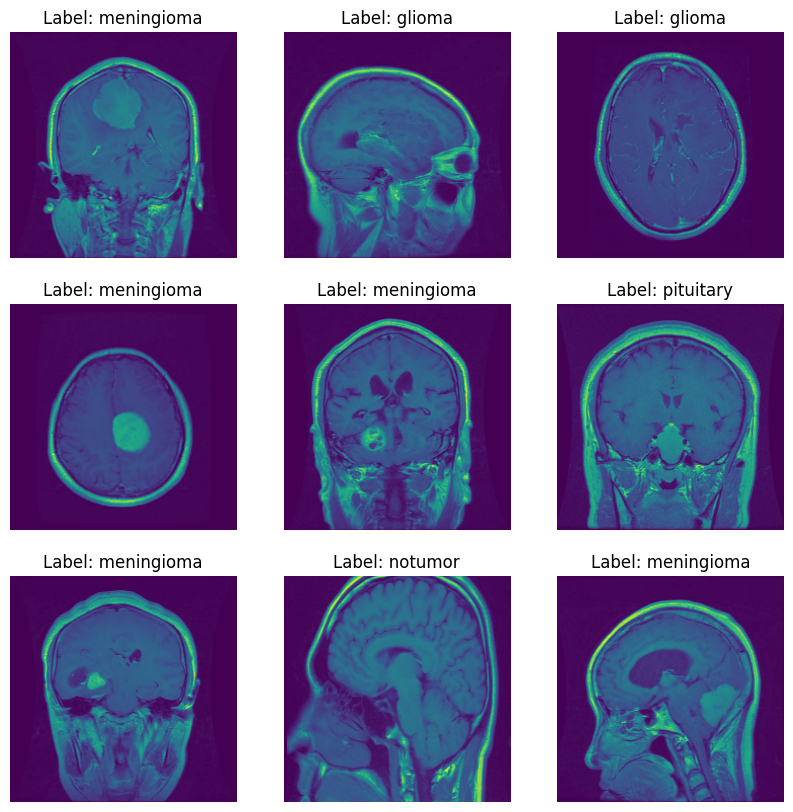

In [12]:
#Function to display a few images from the dataset 

def display_images(dataset, class_names, num_images=9):
    plt.figure(figsize=(10, 10))
    for i, (image, label) in enumerate(dataset.take(1)):  # Take one batch from the dataset
        for j in range(num_images):  # Display 9 images
            plt.subplot(3, 3, j+1)  # Create a 3x3 grid
            plt.imshow(image[j].numpy().astype("uint8"))  # Convert image tensor to numpy and show
            label_name = class_names[label[j].numpy()]  # Map the label index to class name
            plt.title(f"Label: {label_name}")  # 
            plt.axis('off') 
        plt.show()
        break  
        
display_images(train_dataset, train_class_names)

<h2> Data Preprocessing </h2>

<h4> Data Augmentation </h4>

In [13]:
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomTranslation, RandomContrast, RandomBrightness, GaussianNoise

In [14]:
data_augmentation = tf.keras.Sequential([
    RandomFlip('horizontal'),
    RandomFlip('vertical'),
    RandomRotation(0.2),
    RandomZoom(0.3),
    RandomTranslation(height_factor=0.2, width_factor =0.2),
    RandomContrast(factor=0.001),
    RandomBrightness(factor = 0.001),
    GaussianNoise(0.1)
])

<h4> Normalization </h4>

In [15]:
def preprocess (image, label, training = True):
    if training:
        mage = data_augmentation(image)
    image = tf.image.resize(image,(224,224))
    image = image/255
    return image, label

train_dataset_aug = train_dataset.map(lambda x,y: preprocess(x,y, training = True))
val_dataset_aug = val_dataset.map(lambda x,y: preprocess(x,y, training = False))
test_dataset_aug = test_dataset.map(lambda x, y:preprocess(x,y,training = False))

<h4> Display some preprocessed data </h4>

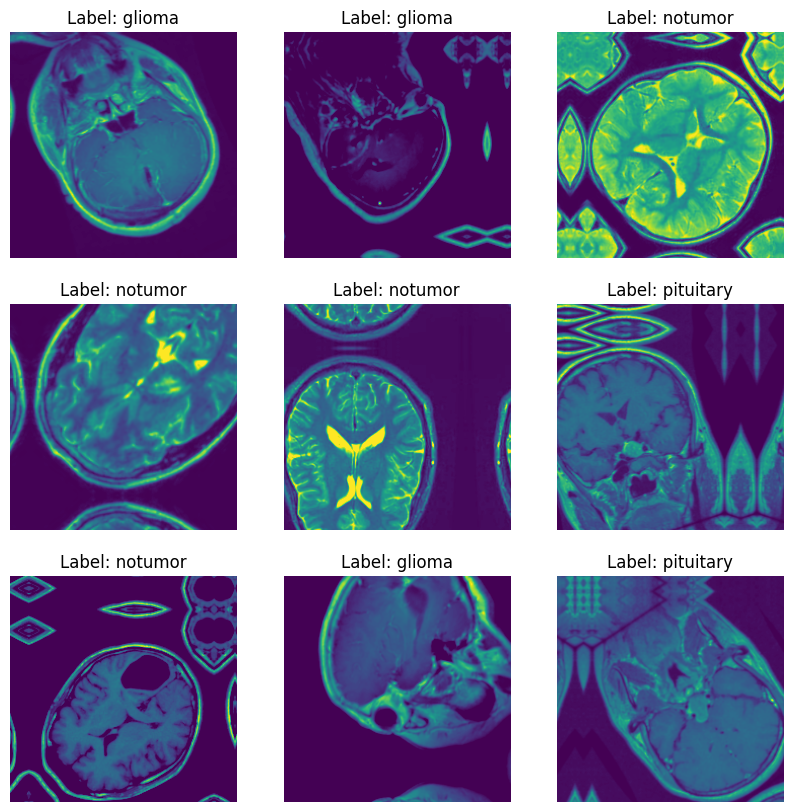

In [16]:
def display_augmented_images(dataset, class_names, num_images=9):
    plt.figure(figsize=(10, 10))
    for i, (image, label) in enumerate(dataset.take(1)):
        for j in range(num_images): 
            augmented_image = data_augmentation(image[j:j+1])  # Apply augmentation to one image at a time
            augmented_image = augmented_image[0] * 255.0  # Convert back to [0, 255] range
            augmented_image = tf.clip_by_value(augmented_image, 0, 255)  
            plt.subplot(3, 3, j+1)  # Create a 3x3 grid
            plt.imshow(augmented_image.numpy().astype("uint8"))  # Convert to NumPy and display
            label_name = class_names[label[j].numpy()] 
            plt.title(f"Label: {label_name}")  
            plt.axis('off')  
        plt.show()
        break  

display_augmented_images(train_dataset_aug, train_class_names)


<h2> Model Building </h2>

In [17]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Flatten, Dense, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2

In [32]:
model = Sequential([
    Input(shape = (224,224,1)),

    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2,2)),
    BatchNormalization(),
    Dropout(0.2),
    
    #secondblock
    Conv2D(64, (3,3), activation = 'relu', kernel_regularizer = l2(0.001)),
    MaxPooling2D((2,2)),
    BatchNormalization(),
    Dropout(0.3),
    
    #ThirdBlock
    Conv2D(128, (3,3), activation = 'relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2,2)),
    BatchNormalization(),
    Dropout(0.4),
    
    #Fully Connected Layer
    Flatten(),
    Dense(256, activation = 'relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    
    #output
    Dense(len(train_class_names), activation = 'softmax')
])

In [33]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 222, 222, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 111, 111, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 54, 54, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 26, 26, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,246,020 (84.86 MB)

 Trainable params: 22,245,572 (84.86 MB)

 Non-trainable params: 448 (1.75 KB)

<h2> Compile Model </h2>

In [34]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [35]:
model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy']
             )

In [36]:
#Define lr scheduler
lr_scheduler = ReduceLROnPlateau(
        monitor = 'val_loss',
        factor = 0.5,
        patience =3,
        min_lr = 1e-6,
        verbose =1 
)
    

In [37]:
#train model
early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor = 'val_accuracy',
        patience = 6,
        restore_best_weights = True
)

history = model.fit(train_dataset_aug,
                    validation_data = val_dataset_aug,
                    epochs = 100,
                    callbacks = [early_stopping, lr_scheduler]
)

Epoch 1/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 87s 582ms/step - accuracy: 0.5485 - loss: 6.1024 - val_accuracy: 0.2697 - val_loss: 11.6335 - learning_rate: 0.0010
Epoch 2/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 107s 751ms/step - accuracy: 0.6603 - loss: 2.3934 - val_accuracy: 0.3319 - val_loss: 6.0570 - learning_rate: 0.0010
Epoch 3/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 116s 811ms/step - accuracy: 0.7078 - loss: 2.2066 - val_accuracy: 0.2706 - val_loss: 17.9841 - learning_rate: 0.0010
Epoch 4/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 113s 792ms/step - accuracy: 0.6937 - loss: 2.5900 - val_accuracy: 0.3485 - val_loss: 7.1672 - learning_rate: 0.0010
Epoch 5/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 114s 798ms/step - accuracy: 0.7166 - loss: 2.2454 - val_accuracy: 0.5158 - val_loss: 5.0123 - learning_rate: 0.0010
Epoch 6/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 113s 793ms/step - accuracy: 0.7478 - loss: 2.0511 - val_accuracy: 0.7776 - val_loss: 1.8860 - learning_rate: 0.0010
Epoch 7/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 113s 793ms/step 

<h3> Test Accuracy and Test Loss Evaluation </h3>

In [38]:
test_loss, test_accuracy = model.evaluate(test_dataset_aug)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test_accuracy: {test_accuracy:.4f}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 0.9163 - loss: 1.0809
Test Loss: 1.0207
Test_accuracy: 0.9413


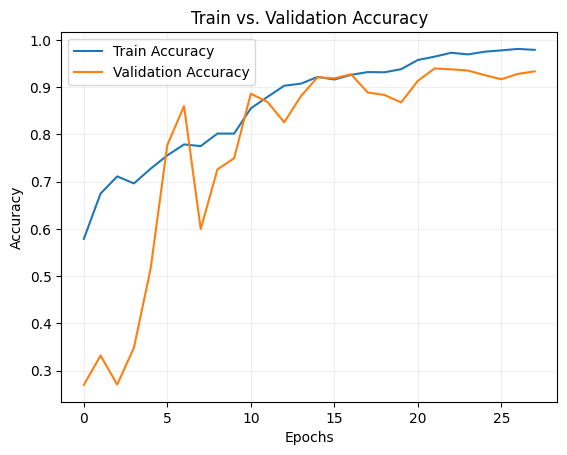

In [40]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']


plt.plot(train_accuracy, label = 'Train Accuracy')
plt.plot(val_accuracy, label = 'Validation Accuracy')
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.title("Train vs. Validation Accuracy")
plt.legend()
plt.grid(alpha =0.2)
plt.savefig('CNN from scratch Accuracy')
plt.show()


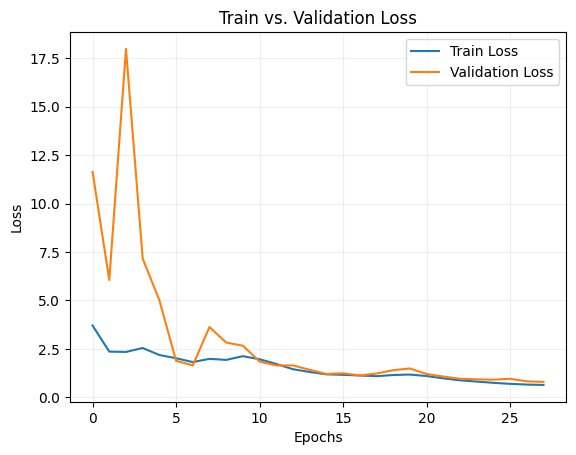

In [41]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']


plt.plot(train_loss, label = 'Train Loss')
plt.plot(val_loss, label = 'Validation Loss')
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.title("Train vs. Validation Loss")
plt.legend()
plt.grid(alpha =0.2)
plt.savefig('CNN from scratch Loss')
plt.show()


<h3> Confusion Matrix </h3>

In [42]:
# Generate predictions
y_pred_probs = model.predict(test_dataset_aug)  # Get predicted probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels

# Extract true labels
y_true = np.concatenate([y.numpy() for _, y in test_dataset], axis=0)


41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step


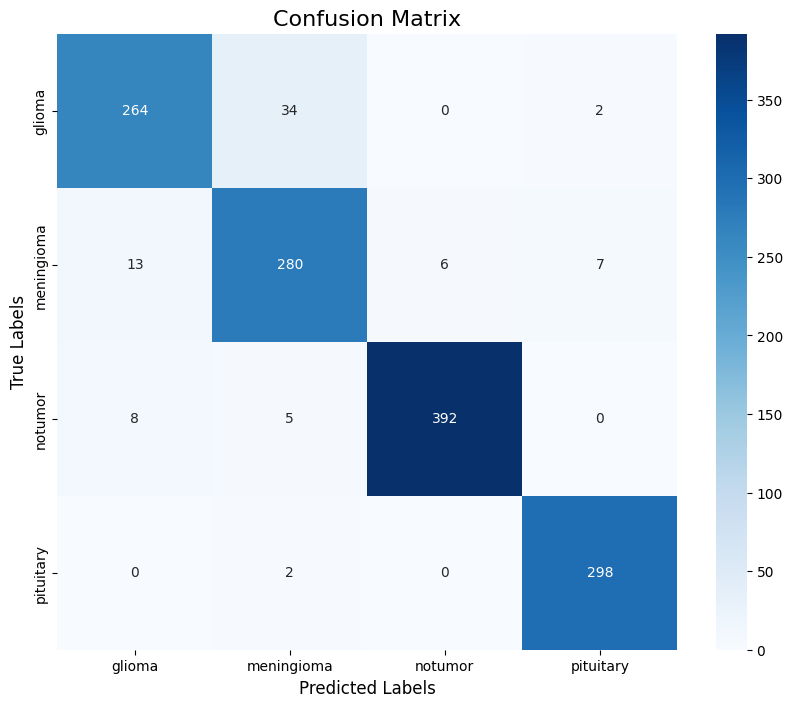

In [44]:
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

import matplotlib.pyplot as plt
import seaborn as sns

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_class_names, yticklabels=test_class_names)
plt.title("Confusion Matrix", fontsize=16)
plt.xlabel("Predicted Labels", fontsize=12)
plt.ylabel("True Labels", fontsize=12)
plt.savefig('Confusion Matrix CNN from Scratch')
plt.show()


<h3> Evaluation </h3>

In [45]:
# Extract training history
history_data = history.history  # Access the history attribute

# Compute the mean and standard deviation for loss
train_loss = history_data['loss']
val_loss = history_data['val_loss']

train_loss_mean = np.mean(train_loss)
train_loss_std = np.std(train_loss)
val_loss_mean = np.mean(val_loss)
val_loss_std = np.std(val_loss)

# Compute the confidence interval (95%) for loss
def confidence_interval(data, confidence=0.95):
    n = len(data)
    mean = np.mean(data)
    se = np.std(data) / np.sqrt(n)  # Standard Error
    h = se * 1.96  # t-value for 95% CI
    return mean - h, mean + h

# Confidence interval for training and validation loss
train_loss_ci = confidence_interval(train_loss)
val_loss_ci = confidence_interval(val_loss)

print(f"Train Loss - Mean: {train_loss_mean:.4f}, Std: {train_loss_std:.4f}, 95% CI: {train_loss_ci}")
print(f"Validation Loss - Mean: {val_loss_mean:.4f}, Std: {val_loss_std:.4f}, 95% CI: {val_loss_ci}")

# Compute the mean and standard deviation for accuracy
train_accuracy = history_data['accuracy']
val_accuracy = history_data['val_accuracy']

train_acc_mean = np.mean(train_accuracy)
train_acc_std = np.std(train_accuracy)
val_acc_mean = np.mean(val_accuracy)
val_acc_std = np.std(val_accuracy)

# Compute the confidence interval (95%) for accuracy
train_acc_ci = confidence_interval(train_accuracy)
val_acc_ci = confidence_interval(val_accuracy)

print(f"Train Accuracy - Mean: {train_acc_mean:.4f}, Std: {train_acc_std:.4f}, 95% CI: {train_acc_ci}")
print(f"Validation Accuracy - Mean: {val_acc_mean:.4f}, Std: {val_acc_std:.4f}, 95% CI: {val_acc_ci}")

Train Loss - Mean: 1.5323, Std: 0.7077, 95% CI: (1.2701950330374059, 1.7944792294521856)
Validation Loss - Mean: 2.9445, Std: 3.7419, 95% CI: (1.5584851085824523, 4.330518525870367)
Train Accuracy - Mean: 0.8639, Std: 0.1109, 95% CI: (0.8228187870375288, 0.9049711514123309)
Validation Accuracy - Mean: 0.7767, Std: 0.2171, 95% CI: (0.6963052499896365, 0.8571098100536985)


<h3> Classification Report </h3>

In [49]:
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report 

# Predicting on the training data
train_true_labels = []
train_pred_labels = []

for images, labels in train_dataset_aug:
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)  # Convert probabilities to predicted class
    train_true_labels.extend(labels.numpy())  # True labels
    train_pred_labels.extend(predicted_labels)  # Predicted labels

# Predicting on the validation data
val_true_labels = []
val_pred_labels = []

for images, labels in val_dataset_aug:
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)  # Convert probabilities to predicted class
    val_true_labels.extend(labels.numpy())  # True labels
    val_pred_labels.extend(predicted_labels)  # Predicted labels

# Calculate F1 score for training data
train_f1_score = f1_score(train_true_labels, train_pred_labels, average='weighted')  # Use 'weighted' for class imbalance
# Calculate F1 score for validation data
val_f1_score = f1_score(val_true_labels, val_pred_labels, average='weighted')  # Use 'weighted' for class imbalance

print(f"Training F1 Score: {train_f1_score:.4f}")
print(f"Validation F1 Score: {val_f1_score:.4f}")

# You can also print a full classification report with precision, recall, and F1 for each class
print("\nClassification Report for Training Data:")
print(classification_report(train_true_labels, train_pred_labels, target_names=train_class_names))

print("\nClassification Report for Validation Data:")
print(classification_report(val_true_labels, val_pred_labels, target_names=val_class_names))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

<h3> ROC Curve </h3>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

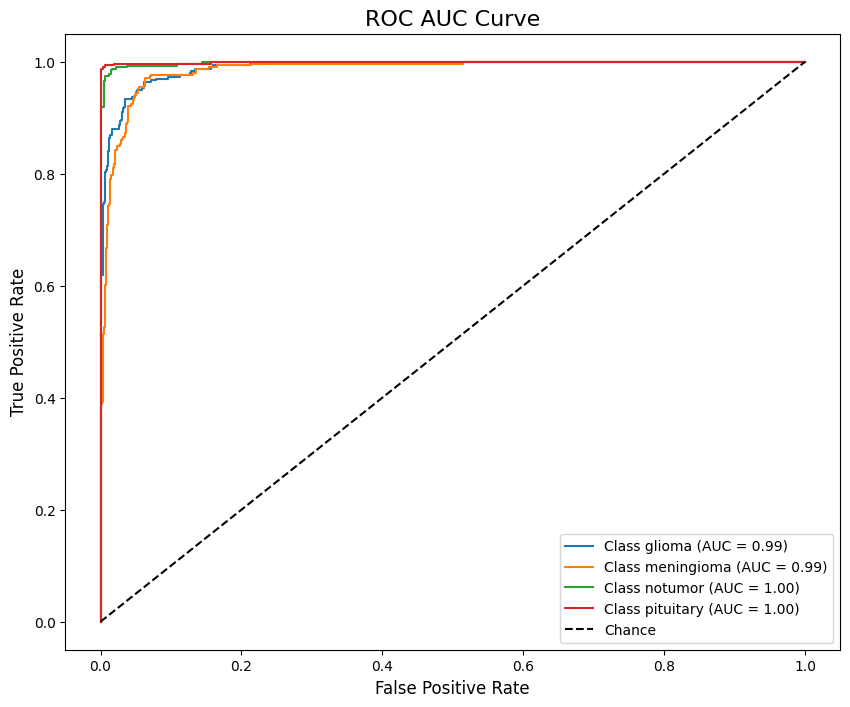

In [50]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Get true labels and predictions
y_true = []
y_pred_proba = []

for images, labels in test_dataset_aug:
    y_true.extend(labels.numpy())
    y_pred_proba.extend(model.predict(images))

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred_proba = np.array(y_pred_proba)

# Binarize the labels for multi-class ROC
y_true_binarized = label_binarize(y_true, classes=range(len(test_class_names)))

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(test_class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves
plt.figure(figsize=(10, 8))
for i, class_name in enumerate(test_class_names):
    plt.plot(fpr[i], tpr[i], label=f'Class {class_name} (AUC = {roc_auc[i]:.2f})')

# Plot diagonal
plt.plot([0, 1], [0, 1], 'k--', label='Chance')

# Add labels and legend
plt.title('ROC AUC Curve', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.legend(loc='lower right', fontsize=10)
plt.grid
plt.savefig('ROC AUC Curve (CNN from Scratch)')
plt.show()


<h3> Unseen Image Prediction </h3>

In [61]:
from tensorflow.keras.preprocessing import image


# Function to load and preprocess the image
def load_and_preprocess_image(img_path):
    # Load image in grayscale mode and resize
    img = image.load_img(img_path, target_size=(224, 224), color_mode="grayscale")
    
    # Convert image to numpy array and expand dimensions to match model input shape
    img_array = image.img_to_array(img)  # Shape will be (224, 224, 1)
    img_array = np.expand_dims(img_array, axis=0)  # Shape will be (1, 224, 224, 1)
    
    # Normalize image values to [0, 1]
    img_array = img_array / 255.0
    
    return img_array

# Function to predict the class of the image
def predict_image(model, img_array, class_names):
    # Get model predictions (probabilities)
    predictions = model.predict(img_array)
    
    # Get the predicted class label (index of the highest probability)
    predicted_class_idx = np.argmax(predictions, axis=1)[0]
    
    # Get the predicted class name
    predicted_class_name = class_names[predicted_class_idx]
    
    return predicted_class_name, predictions[0][predicted_class_idx]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted Class: notumor
Prediction Probability: 0.9975


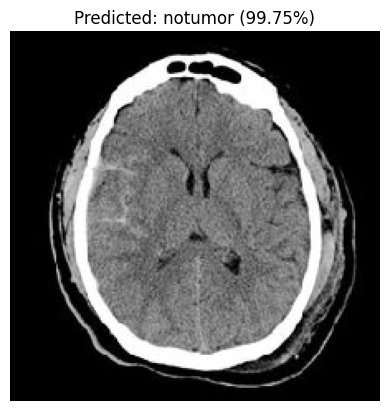

In [64]:
# Load and preprocess the image
img_path = 'D:\\Datasets\\new data\\nt.jpg'  # Provide the path to the MRI image
processed_image = load_and_preprocess_image(img_path)

# Predict the class
predicted_class_name, predicted_prob = predict_image(model, processed_image, test_class_names)

# Display the result
print(f"Predicted Class: {predicted_class_name}")
print(f"Prediction Probability: {predicted_prob:.4f}")

# Display the image and prediction
plt.imshow(processed_image[0].squeeze(), cmap="gray")  # Use cmap="gray" for grayscale images
plt.title(f"Predicted: {predicted_class_name} ({predicted_prob*100:.2f}%)")
plt.axis('off')
plt.show()
